# Sentiment Analysis on Amazon Product Reviews of Uplocked Mobile Phones

* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)

---
<a id="part1"></a>
## Part 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.tokenize import PunktSentenceTokenizer  

import logging


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda, Embedding, LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from tensorflow.keras.layers import Conv1D  # Use Conv1D instead of Convolution1D
from tensorflow.keras import backend as K
from keras.utils import to_categorical



C:\Users\garvb\AppData\Local\Temp\ipykernel_26108\788838899.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Load Data

In [2]:
# Load csv file
df = pd.read_csv('./amazon/data.csv')
df.head()

,Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack,Unnamed: 1,5.0,Reviewed in the United States on 17 September 2023,Omar Mendoza,Fast.
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,NaN,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,NaN,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...


In [3]:
df = df.drop(columns=["Unnamed: 1"])
df.head()

,Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack,5.0,Reviewed in the United States on 17 September 2023,Omar Mendoza,Fast.
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...


In [4]:
df.columns = ["Product", "Rating", "Demographic", "Reviewer", "Comments"]
df

,Product,Rating,Demographic,Reviewer,Comments
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...
...,...,...,...,...,...
110996,Intel Bx80673I97940X CPU Grey,1.0,Reviewed in India on 17 June 2020,Santhosh Philip,Not at all working fake one
110997,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Italy on 19 November 2018,Cliente Amazon,Un mostro di processore
110998,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Germany on 2 July 2018,Henning,Zum Schneiden und Bearbeiten bestens geeignet....
110999,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Spain on 20 May 2019,Latinmau,Puro poder de procesador. Honestamente para lo...


In [5]:
df[['Location', 'Date']] = df['Demographic'].str.extract(r'Reviewed in (.*?) on (.*)')

df = df.drop(columns=["Demographic"])

df.columns = ["Product", "Rating", "Reviewer", "Reviews", "Location", "Date"]
df

,Product,Rating,Reviewer,Reviews,Location,Date
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,F. Machado,Fast CPU and since I did not need the graphics...,the United States,27 September 2022
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Omar Mendoza,Fast.,the United States,17 September 2023
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,F. Machado,Fast CPU and since I did not need the graphics...,the United States,27 September 2022
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...,India,3 September 2023
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,yogesh Kumar,Most powerful cpu at this price bracket no dou...,India,28 March 2023
...,...,...,...,...,...,...
110996,Intel Bx80673I97940X CPU Grey,1.0,Santhosh Philip,Not at all working fake one,India,17 June 2020
110997,Intel Bx80673I97940X CPU Grey,5.0,Cliente Amazon,Un mostro di processore,Italy,19 November 2018
110998,Intel Bx80673I97940X CPU Grey,5.0,Henning,Zum Schneiden und Bearbeiten bestens geeignet....,Germany,2 July 2018
110999,Intel Bx80673I97940X CPU Grey,5.0,Latinmau,Puro poder de procesador. Honestamente para lo...,Spain,20 May 2019


In [6]:
distinct_values = df["Product"].unique()

print("Distinct values in Column1:")
for value in distinct_values:
    print(value)

Distinct values in Column1:
Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack
Intel Core i7-13700K Desktop Processor 16 cores (8 P-cores + 8 E-cores) 30M Cache, up to 5.4 GHz Socket LGA 1700
Intel Core i7 (12th Gen) i7-12700 Dodeca-core (12 Core) 2.10 GHz Processor - Retail Pack
Intel Core i9-13900K Desktop Processor LGA 1700 24 cores (8 P-cores + 16 E-cores) 36M Cache, up to 5.8 GHz'
Intel Core i7-13700KF Gaming Desktop Processor 16 cores (8 P-cores + 8 E-cores) - Unlocked
Intel® Core™ i9-13900KS Processor 36M Cache, up to 6.00 GHz
Intel® Core™ i9-14900KS Desktop Processor 24 cores (8 P-cores + 16 E-cores)
Intel CM8070104291318 Core I3-10100f 3.6ghz Lga1200 Chip Tray Cpu Mm 999wpa
Intel Core i9-12900K Desktop Processor16 (8P+8E) Cores up to 5.2 GHz Unlocked LGA1700 600 Series Chipset 125W
Intel Core i7 12700F 12 Gen Desktop PC Processor 12 Core CPU with 25MB Cache and up to 4.9 GHz Clock Speed LGA 1700 4K (Graphic Card Required)
Intel Core I5 

In [7]:
def extract_info(row):
    # Split the text by spaces
    parts = row.split()
    # Extract relevant information
    brand = parts[0]
    try:
        # Extracting model till 'Processor' for processors, 'Laptop' for laptops, 'Graphics' for graphics card, 'Camera' for camera, 'NUC' for mini pc, 'Motherboard' for Motherboard
        if 'Processor' in row:
            model = ' '.join(parts[1:parts.index('Processor')])
        elif 'Laptop' in row:
            model = ' '.join(parts[parts.index('Laptop') + 1:parts.index('Processor')]) + ' Laptop'
        elif 'Graphics' in row:
            model = ' '.join(parts[:parts.index('Graphics')]) + ' Graphics Card'
        elif 'Camera' in row:
            model = ' '.join(parts[:parts.index('Camera')]) + ' Camera'
        elif 'NUC' in row:
            model = ' '.join(parts[:parts.index('NUC')]) + ' Mini PC'
        elif 'Motherboard' in row:
            model = ' '.join(parts[:parts.index('Motherboard')]) + ' Motherboard'
        else:
            model = 'N/A'
    except ValueError:
        # If the keyword is not found, set model as N/A
        model = 'N/A'
    return pd.Series([brand, model])

# Apply the function to the DataFrame and concatenate the results
df[['Brand', 'Model']] = df['Product'].apply(extract_info)

# Drop the original column
df.drop('Product', axis=1, inplace=True)

# Display the resulting DataFrame
print(df)

        Rating                                           Reviewer  \
0          5.0                                         F. Machado   
1          5.0                                       Omar Mendoza   
2          5.0                                         F. Machado   
3          5.0  This processor is absolutely incredible with n...   
4          5.0                                       yogesh Kumar   
...        ...                                                ...   
110996     1.0                                    Santhosh Philip   
110997     5.0                                     Cliente Amazon   
110998     5.0                                            Henning   
110999     5.0                                          Latinmau    
111000     5.0                               Mag Guenther Hofmann   

                                                  Reviews           Location  \
0       Fast CPU and since I did not need the graphics...  the United States   
1          

In [8]:
# Remove rows where Model is 'N/A'
df = df[df['Model'] != 'N/A']

# Remove rows where Brand doesn't come under Intel
intel_brands = ['Intel', 'Intel®', 'IntelCorei9-10900X', 'INTEL']
df = df[df['Brand'].isin(intel_brands)]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df

,Rating,Reviewer,Reviews,Location,Date,Brand,Model
0,5.0,F. Machado,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
1,5.0,Omar Mendoza,Fast.,the United States,17 September 2023,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
2,5.0,F. Machado,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
3,5.0,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...,India,3 September 2023,Intel,Core i7-13700K Desktop
4,5.0,yogesh Kumar,Most powerful cpu at this price bracket no dou...,India,28 March 2023,Intel,Core i7-13700K Desktop
...,...,...,...,...,...,...,...
70378,5.0,Js bibra,the review is good anyway being an intel produ...,India,14 July 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
70379,5.0,Amazon Customer,"good service by amazon, my pros. k380 , deepc...",India,4 December 2015,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
70380,5.0,ankur goel,"Ultra fast 6th gen skylake processor , great f...",India,18 March 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
70381,5.0,SuperDrive,I have used several older models of NUC before...,the United States,11 July 2023,Intel,NUC 13 Pro NUC13ANHi7 Barebone System - Socket...


In [9]:
# Rearrange the columns
df = df[['Brand', 'Model', 'Rating', 'Date', 'Location','Reviewer','Reviews']]
df

,Brand,Model,Rating,Date,Location,Reviewer,Reviews
0,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,27 September 2022,the United States,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,17 September 2023,the United States,Omar Mendoza,Fast.
2,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,27 September 2022,the United States,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel,Core i7-13700K Desktop,5.0,3 September 2023,India,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel,Core i7-13700K Desktop,5.0,28 March 2023,India,yogesh Kumar,Most powerful cpu at this price bracket no dou...
...,...,...,...,...,...,...,...
70378,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,14 July 2016,India,Js bibra,the review is good anyway being an intel produ...
70379,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,4 December 2015,India,Amazon Customer,"good service by amazon, my pros. k380 , deepc..."
70380,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,18 March 2016,India,ankur goel,"Ultra fast 6th gen skylake processor , great f..."
70381,Intel,NUC 13 Pro NUC13ANHi7 Barebone System - Socket...,5.0,11 July 2023,the United States,SuperDrive,I have used several older models of NUC before...


### Data Exploration

In [10]:
# Summary statistics of numerical features
print("Summary statistics of numerical features:\n", df.describe())

# Total number of reviews
total_reviews = len(df)
print("\nTotal number of reviews:", total_reviews)

# Total number of unique products
unique_products = len(df['Model'].unique())
print("\nTotal number of unique products:", unique_products)

# Percentage of reviews with neutral sentiment
neutral_percentage = (df[df['Rating'] == 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with neutral sentiment: {:.2f}%".format(neutral_percentage))

# Percentage of reviews with positive sentiment
positive_percentage = (df[df['Rating'] > 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with positive sentiment: {:.2f}%".format(positive_percentage))

# Percentage of reviews with negative sentiment
negative_percentage = (df[df['Rating'] < 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with negative sentiment: {:.2f}%".format(negative_percentage))


Summary statistics of numerical features:
              Rating
count  70383.000000
mean       4.427390
std        1.224546
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000

Total number of reviews: 70383

Total number of unique products: 102

Percentage of reviews with neutral sentiment: 3.27%

Percentage of reviews with positive sentiment: 84.88%

Percentage of reviews with negative sentiment: 10.86%


### Data Visualization 

Text(0, 0.5, 'Count')

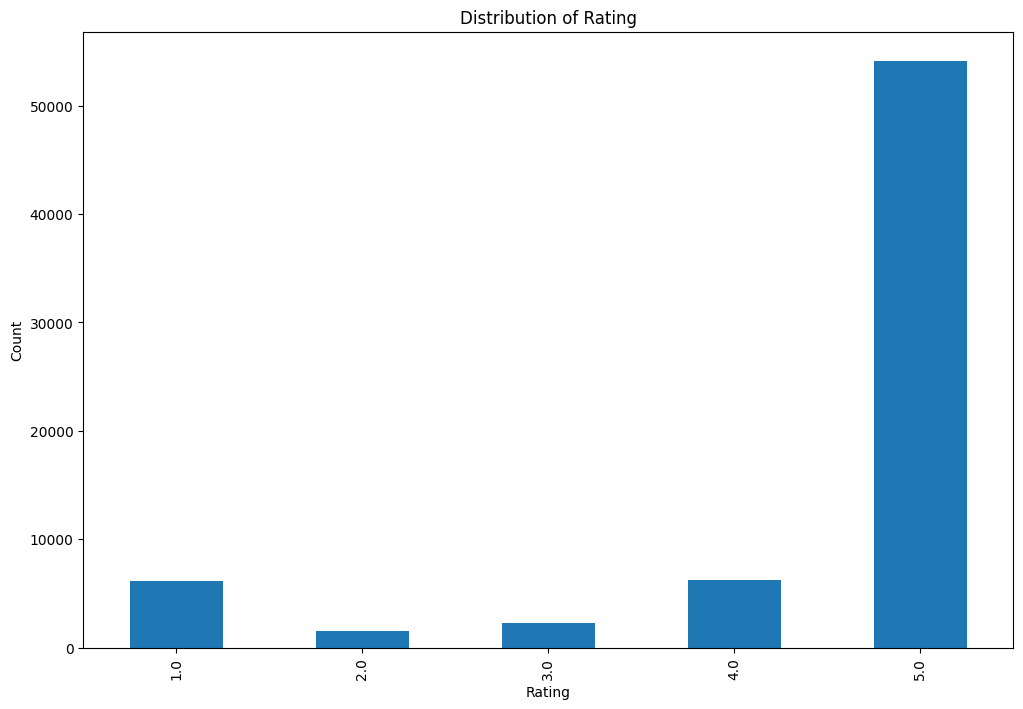

In [11]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Highest-Reviewed Products')

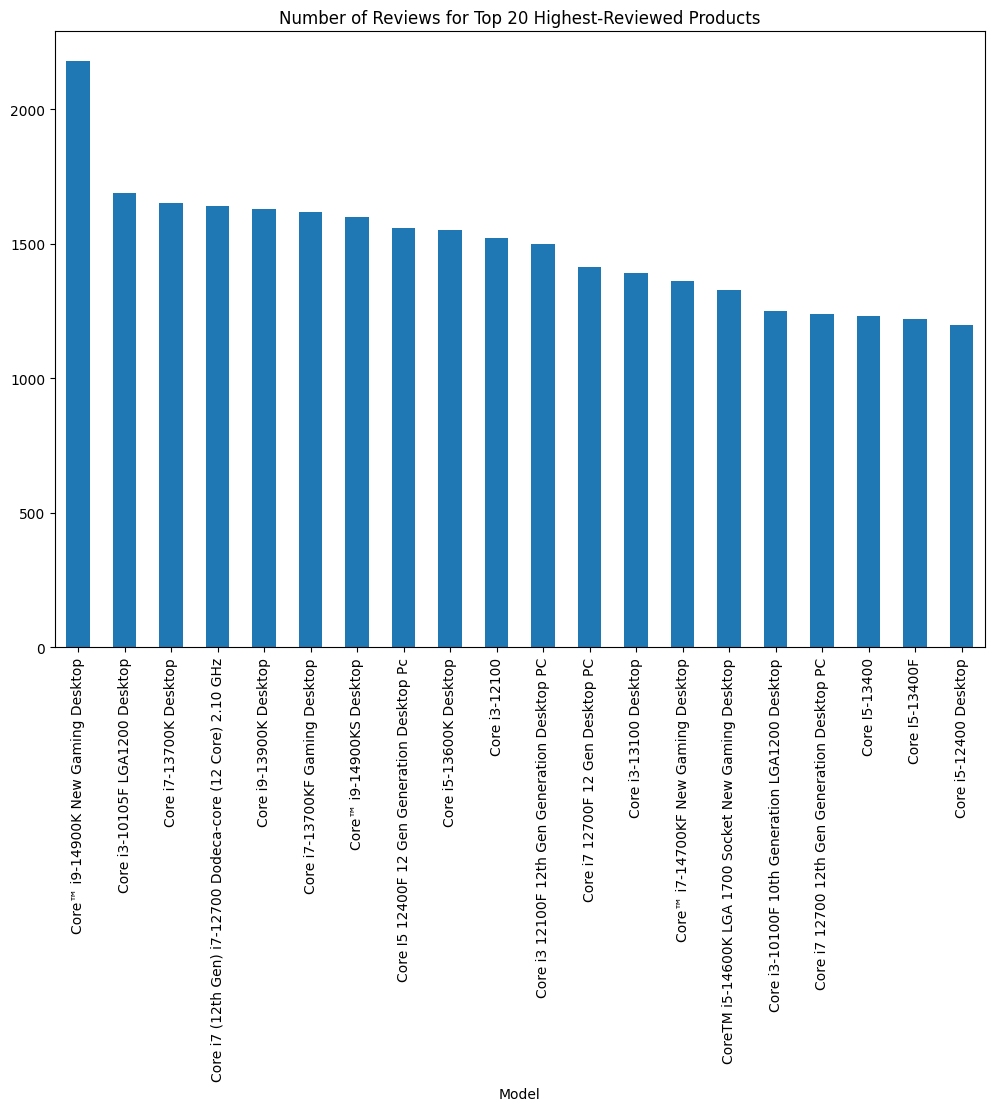

In [12]:
# Plot number of reviews for top 20 brands
brands = df["Model"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Highest-Reviewed Products")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Highest-Reviewed Products')

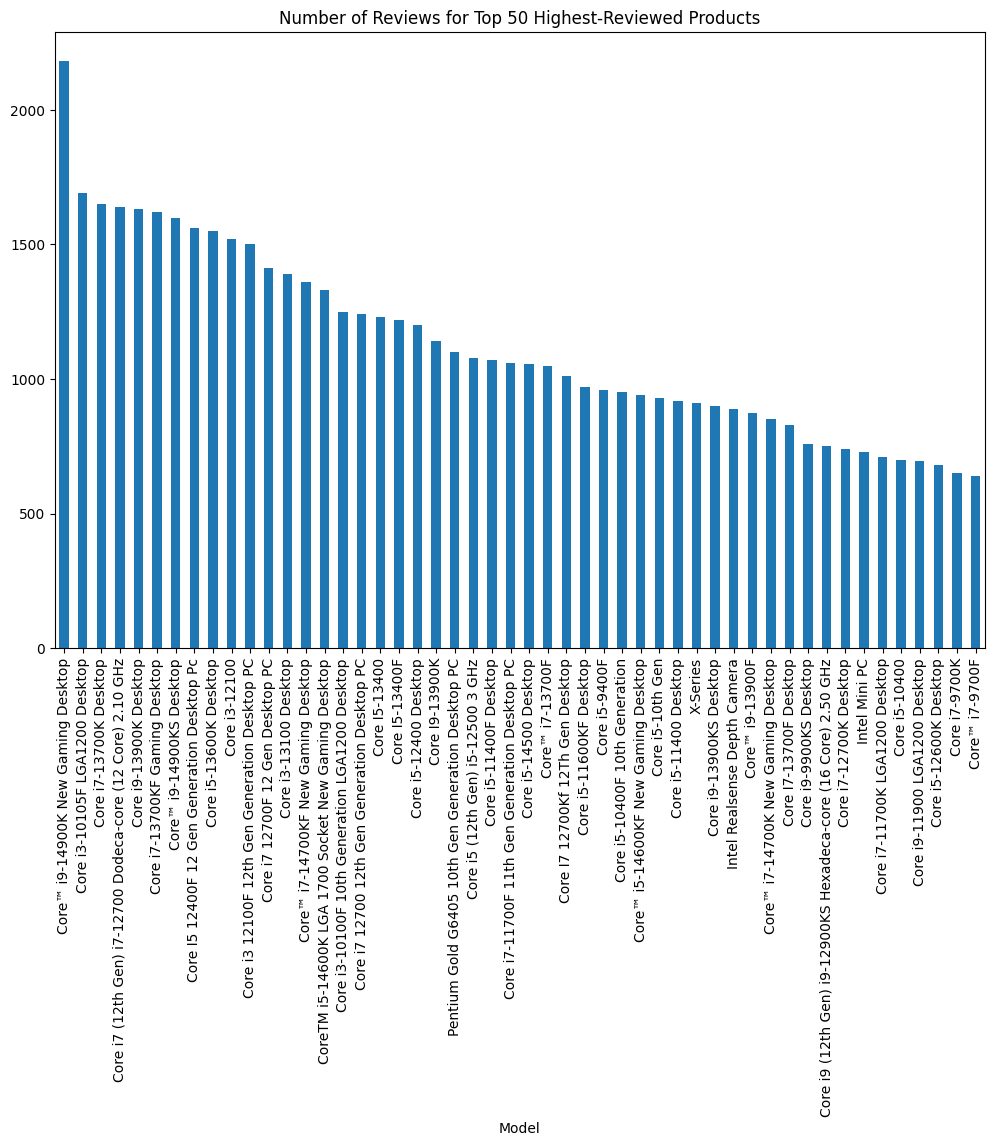

In [13]:
# Plot number of reviews for top 50 products
products = df["Model"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Highest-Reviewed Products")

Text(0, 0.5, 'Count')

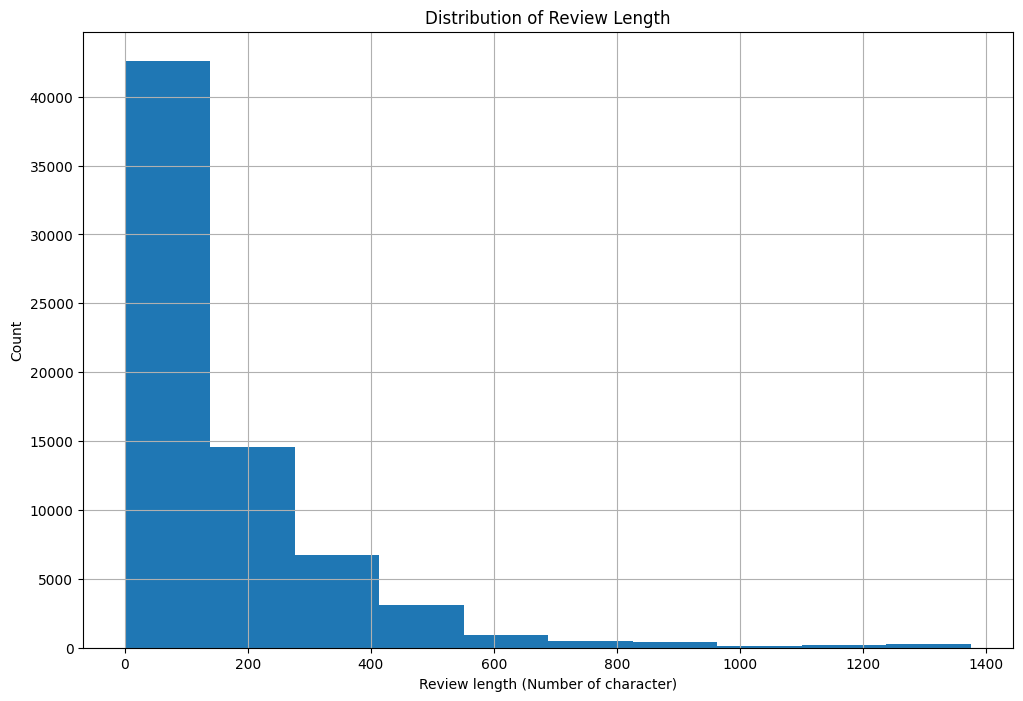

In [14]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

---
<a id="part2"></a>
## Part 2. Data Preparation

For illustrative purpose, I use only 10% of the data in this project. To simply the problem, I only consider reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2), and drop reviews with neutral sentiment (rating 3). 


### Prepare Data

In [15]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Brand,Model,Rating,Date,Location,Reviewer,Reviews,Sentiment
34947,Intel,Core i3-14100F Desktop,5.0,14 April 2024,the United States,Leroy Dodd,The processor can in fine. I thought I was bei...,1
38571,Intel,7th Gen Intel Core Desktop,5.0,8 September 2017,India,Amazon Customer,Good,1
61373,Intel®,Core™ i7-14700KF New Gaming Desktop,1.0,28 March 2024,India,Sumit Kumar,I don't liked the price of it .,0
18413,Intel,Core i7-13700KF Gaming Desktop,5.0,24 January 2024,the United States,elba,The Intel Core i7-13700KF Gaming Desktop Proce...,1
47418,Intel®,Core™ i9-14900K New Gaming Desktop,5.0,11 March 2024,France,Stéphanie MAYRAND,"Le processeur haut de gamme du moment, par Int...",1


### Train Test Split 

In [16]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 6060 training examples and 674 validation examples. 

Show a review in the training set : 
 This processor is all-rounder for every tasks you do on PC from small to CPU intensive applications. If you are looking for vast performance with heavy production tasks this is very nice to have. Best to use with Motherboard DDR5 and PCI-E 5.0 supported motherboards.


---
<a id="part3"></a>
## Part 3. Bag of Words

The goal of this project is to classify the reviews into positive and negative sentiment. There are two main steps involved. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

* Step 1 : Preprocess raw reviews to cleaned reviews
* Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
* Step 3 : Transform review text to numerical representations (feature vectors)
* Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
* Step 5 : Improve the model performance by GridSearch

### Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [27]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [18]:
from bs4 import BeautifulSoup
import numpy as np

# Assuming X_train and X_test are lists of text data
# Define a function to clean text data
def cleanText(raw_text):
    # Remove HTML tags
    text = BeautifulSoup(raw_text, 'lxml').get_text()
    # Add more text cleaning steps as needed
    return text

# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))


C:\Users\garvb\AppData\Local\Temp\ipykernel_26108\2912041083.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()


Show a cleaned review in the training set : 
 This processor is all-rounder for every tasks you do on PC from small to CPU intensive applications. If you are looking for vast performance with heavy production tasks this is very nice to have. Best to use with Motherboard DDR5 and PCI-E 5.0 supported motherboards.


### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm. 

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" % len(countVect.get_feature_names_out())) #6378 
print("Show some feature names : \n", countVect.get_feature_names_out()[::1000])

# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)


Number of features : 5111 

Show some feature names : 
 ['000' 'capabilities' 'fungerar' 'nervous' 'seeing' 'youtube']


MultinomialNB()

In [20]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [21]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9748

AUC score : 0.9723

Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.97      0.88        65
           1       1.00      0.98      0.99       609

    accuracy                           0.97       674
   macro avg       0.90      0.97      0.93       674
weighted avg       0.98      0.97      0.98       674


Confusion Matrix : 
 [[ 63   2]
 [ 15 594]]


### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus. 

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [22]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out())) #1722
print("Show some feature names : \n", tfidf.get_feature_names_out()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 4105 

Show some feature names : 
 ['000' 'connaissant' 'irás' 'rarely' 'worried']


LogisticRegression()

In [23]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'overheating' 'broken' 'dislike' 'received' 'ryzen' 'liked' 'sans'
 'it' 'deluso']

Top 10 features with largest coefficients : 
['for' 'de' 'great' 'best' 'good' 'my' 'fast' 'without' 'i5' 'performance']


In [24]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9792

AUC score : 0.8923

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.78      0.88        65
           1       0.98      1.00      0.99       609

    accuracy                           0.98       674
   macro avg       0.99      0.89      0.93       674
weighted avg       0.98      0.98      0.98       674


Confusion Matrix : 
 [[ 51  14]
 [  0 609]]


### Pipeline and GridSearch

In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [25]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 1.0000

AUC score : 1.0000

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00       609

    accuracy                           1.00       674
   macro avg       1.00      1.00      1.00       674
weighted avg       1.00      1.00      1.00       674


Confusion Matrix : 
 [[ 65   0]
 [  0 609]]


---
<a id="part4"></a>
## Part 4. Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Step 2 : Create volcabulary list using Word2Vec model
* Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
* Step 4 : Fit the average feature vectors to Random Forest Classifier

### Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [28]:
# Define the tokenizer
tokenizer = PunktSentenceTokenizer()
def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords))
    return sentences

# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)

print('%d parsed sentences in the training set\n' % len(sentences))
print("Some parsed sentences from the training set:")
for i in range(5):  # Adjust the range as needed
    print(f"Sentence {i+1}: {sentences[i]}")

C:\Users\garvb\AppData\Local\Temp\ipykernel_26108\179031280.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


12453 parsed sentences in the training set

Some parsed sentences from the training set:
Sentence 1: i recently upgraded to the intel core i kf and i m impressed with its performance
Sentence 2: the cores coupled with the ability to reach up to ghz make multitasking a breeze
Sentence 3: one helpful tip pair it with a high quality cooling solution for optimal performance and longevity
Sentence 4: super
Sentence 5: this is essentially a k that is gen earlier


In [29]:
import re

def cleanText(text, remove_stopwords=False):
    '''
    Clean the text, with an option to remove stopwords
    '''
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return ' '.join(words)

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords))
    return sentences

# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer, remove_stopwords=True)

print('%d parsed sentences in the training set\n'  % len(sentences))

print("Some parsed sentences from the training set:")
for i in range(5):  # Adjust the range as needed
    print(f"Sentence {i+1}: {sentences[i]}")

12453 parsed sentences in the training set

Some parsed sentences from the training set:
Sentence 1: recently upgraded intel core kf impressed performance
Sentence 2: cores coupled ability reach ghz make multitasking breeze
Sentence 3: one helpful tip pair high quality cooling solution optimal performance longevity
Sentence 4: super
Sentence 5: essentially k gen earlier


### Creating Volcabulary List using Word2Vec Model

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word vector representations by sepcifiying the embedding dimension (= length of feature vector).

In [30]:
import logging
from gensim.models import Word2Vec

# Enable logging for gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300  # Embedding dimension
min_word_count = 10  # Minimum word count
num_workers = 4  # Number of threads to run in parallel
context = 10  # Context window size
downsampling = 1e-3  # Downsample setting for frequent words

print("Training Word2Vec model ...\n")

# Assume `sentences` is your list of tokenized sentences
w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count,
               window=context, sample=downsampling)

# To make the model memory-efficient
w2v.init_sims(replace=True)

# Save the model
w2v.save("w2v_300features_10minwordcounts_10context")

print("Number of words in the vocabulary list: %d \n" % len(w2v.wv.index_to_key))  # Use index_to_key instead of index2word
print("Show first 10 words in the vocabulary list: \n", w2v.wv.index_to_key[:10])


2024-06-03 16:31:38,477 : INFO : collecting all words and their counts
2024-06-03 16:31:38,481 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2024-06-03 16:31:38,483 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-03 16:31:38,635 : INFO : PROGRESS: at sentence #10000, processed 578922 words, keeping 27 word types
2024-06-03 16:31:38,673 : INFO : collected 27 word types from a corpus of 715983 raw words and 12453 sentences


Training Word2Vec model ...



2024-06-03 16:31:38,676 : INFO : Creating a fresh vocabulary
2024-06-03 16:31:38,679 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 27 unique words (100.00% of original 27, drops 0)', 'datetime': '2024-06-03T16:31:38.679898', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2024-06-03 16:31:38,684 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 715983 word corpus (100.00% of original 715983, drops 0)', 'datetime': '2024-06-03T16:31:38.684633', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2024-06-03 16:31:38,689 : INFO : deleting the raw counts dictionary of 27 items
2024-06-03 16:31:38,693 : INFO : sample=0.001 downsamples 26 most-common word

Number of words in the vocabulary list: 27 

Show first 10 words in the vocabulary list: 
 [' ', 'e', 'o', 'a', 'r', 's', 'i', 'n', 't', 'c']


In [31]:
import logging
from gensim.models import Word2Vec

# Enable logging for gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300  # Embedding dimension
min_word_count = 10  # Minimum word count
num_workers = 4  # Number of threads to run in parallel
context = 10  # Context window size
downsampling = 1e-3  # Downsample setting for frequent words

print("Training Word2Vec model ...\n")

# Assume `sentences` is your list of tokenized sentences
w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count,
               window=context, sample=downsampling)

# To make the model memory-efficient
w2v.init_sims(replace=True)

# Save the model
w2v.save("w2v_300features_10minwordcounts_10context")

print("Number of words in the vocabulary list: %d \n" % len(w2v.wv.index_to_key))  # Use index_to_key instead of index2word
print("Show first 10 words in the vocabulary list: \n", w2v.wv.index_to_key[:10])


2024-06-03 16:31:41,244 : INFO : collecting all words and their counts
2024-06-03 16:31:41,248 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2024-06-03 16:31:41,250 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-03 16:31:41,411 : INFO : PROGRESS: at sentence #10000, processed 578922 words, keeping 27 word types


Training Word2Vec model ...



2024-06-03 16:31:41,444 : INFO : collected 27 word types from a corpus of 715983 raw words and 12453 sentences
2024-06-03 16:31:41,447 : INFO : Creating a fresh vocabulary
2024-06-03 16:31:41,450 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 27 unique words (100.00% of original 27, drops 0)', 'datetime': '2024-06-03T16:31:41.450416', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2024-06-03 16:31:41,452 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 715983 word corpus (100.00% of original 715983, drops 0)', 'datetime': '2024-06-03T16:31:41.452345', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2024-06-03 16:31:41,456 : INFO : deleting the 

Number of words in the vocabulary list: 27 

Show first 10 words in the vocabulary list: 
 [' ', 'e', 'o', 'a', 'r', 's', 'i', 'n', 't', 'c']


### Averaging Feature Vectors

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review. 

In [32]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index_to_key) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model.wv.word_vec(word))
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [33]:
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" % trainVector.shape)

# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" % testVector.shape)

C:\Users\garvb\AppData\Local\Temp\ipykernel_26108\3440702079.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  featureVec = np.add(featureVec, model.wv.word_vec(word))


Training set : 6060 feature vectors with 300 dimensions
Validation set : 674 feature vectors with 300 dimensions


### Random Forest Classifer

We can now train Random Forest Classifier using feature vectors of reviews in the training set. 

In [34]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.9941

AUC score : 0.9692

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        65
           1       0.99      1.00      1.00       609

    accuracy                           0.99       674
   macro avg       1.00      0.97      0.98       674
weighted avg       0.99      0.99      0.99       674


Confusion Matrix : 
 [[ 61   4]
 [  0 609]]


---
<a id="part5"></a>
## Part 5. LSTM

Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative  sentiment using Keras libarary.

### Simple LSTM

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.
* Step 1 : Prepare X_train and X_test to 2D tensor
* Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [35]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

C:\Users\garvb\anaconda3\envs\Devshouse\lib\site-packages\keras\src\legacy\preprocessing\text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


X_train shape: (6060, 100)
X_test shape: (674, 100)
y_train shape: (6060, 2)
y_test shape: (674, 2)


In [39]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(LSTM(128)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evaluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
190/190 ━━━━━━━━━━━━━━━━━━━━ 35s 151ms/step - accuracy: 0.8877 - loss: 0.3490
Epoch 2/3
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.9948 - loss: 0.0159
Epoch 3/3
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - accuracy: 0.9991 - loss: 0.0036
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 1.0000 - loss: 4.9177e-04
Test loss : 0.0006
Test accuracy : 1.0000


In [40]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 2)


### LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account.  The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to 
intialize the weights of embedding layer in LSTM.

* Step 1 : Load pretrained word embedding model
* Step 2 : Construct embedding layer using embedding matrix as weights
* Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [42]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

2024-06-03 16:37:19,021 : INFO : loading Word2Vec object from w2v_300features_10minwordcounts_10context
2024-06-03 16:37:19,026 : INFO : loading wv recursively from w2v_300features_10minwordcounts_10context.wv.* with mmap=None
2024-06-03 16:37:19,029 : INFO : setting ignored attribute cum_table to None
2024-06-03 16:37:19,032 : INFO : Word2Vec lifecycle event {'fname': 'w2v_300features_10minwordcounts_10context', 'datetime': '2024-06-03T16:37:19.031275', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'loaded'}


Shape of embedding matrix :  (27, 300)


In [44]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (6060, 100)
X_test shape: (674, 100)
y_train shape: (6060, 2)
y_test shape: (674, 2)


In [47]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │         8,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,100 (31.64 KB)

 Trainable params: 8,100 (31.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
190/190 ━━━━━━━━━━━━━━━━━━━━ 28s 117ms/step - accuracy: 0.8925 - loss: 0.3504
Epoch 2/3
190/190 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9110 - loss: 0.2486
Epoch 3/3
190/190 ━━━━━━━━━━━━━━━━━━━━ 16s 82ms/step - accuracy: 0.9212 - loss: 0.2269
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9419 - loss: 0.1724
Test loss : 0.1887
Test accuracy : 0.9392


In [48]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (27, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

In [52]:
def create_word_cloud(brand, sentiment):
    try: 
        df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except: 
        pass

In [53]:
create_word_cloud(brand='Intel', sentiment=1)

In [54]:
create_word_cloud(brand='Intel', sentiment=0)